In [18]:
import qiskit
from qiskit import QuantumCircuit, Aer, QuantumRegister, IBMQ
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [19]:
# IBMQの認証情報をロード
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-07-20 03:36:05,786: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
"""実機マシンのノイズモデルを取得する
"""
backend = provider.get_backend("ibmq_5_yorktown")
noise_model = noise.NoiseModel.from_backend(backend=backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'measure', 'reset', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [5]:
"""取得したノイズモデルを用いて校正用のデータを作成する
"""
qr = qiskit.QuantumRegister(5)
qubit_list = list(range(0, 5))
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel="mcal")

backend = qiskit.Aer.get_backend("qasm_simulator")
shots = 1024
job = qiskit.execute(meas_calibs, backend=backend, shots=shots, noise_model=noise_model)
cal_results = job.result()

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


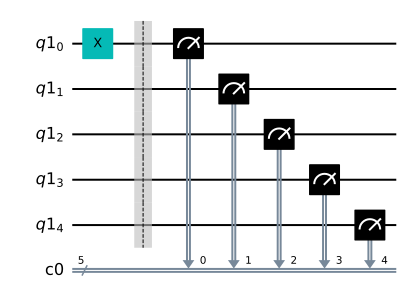

In [11]:
"""校正データを得るために実行する量子回路（meas_calibs）とラベル（state_labels）を生成し、実行する
"""
print(state_labels)

meas_calibs[1].draw("mpl")  # 00001に対応した量子回路を描画

[[0.78125    0.08789062 0.05859375 ... 0.         0.         0.        ]
 [0.05957031 0.75976562 0.00195312 ... 0.00097656 0.         0.        ]
 [0.03613281 0.00097656 0.77832031 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.69140625 0.00683594 0.04589844]
 [0.         0.         0.         ... 0.         0.69726562 0.06738281]
 [0.         0.         0.         ... 0.03710938 0.04492188 0.69140625]]


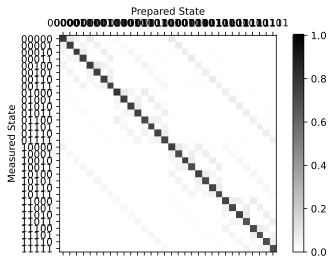

In [13]:
"""測定結果から校正用の行列を生成し、プロットする
表示される行列は、用意された状態に対する測定された状態の分布

2つの状態は一致するので行列は対角成分が1の対角行列になるが、実際のマシンのノイズモデルを入れて計算すると非対角成分も値を持つようになる。

求めた校正行列を用いて、量子コンピュータから得られたエラーを含む出力結果からもとの値を逆算することでエラーの影響が軽減された結果を得ることができる。
"""
meas_fitter = CompleteMeasFitter(cal_results, state_labels=state_labels, qubit_list=qubit_list)

print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

In [15]:
"""GHZ状態 を生成する量子回路でエラー軽減することを確認してみる
理想的な量子コンピュータの場合、q0q1q2の測定結果は|000>または|111>になる

しかし、実際には|00001>などが測定される。
"""
# 量子回路
qc = QuantumCircuit(5, 5)

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure([0,1,2], [0,1,2])

# 実行
backend = provider.get_backend("ibmq_5_yorktown")
shots = 1024
job = qiskit.execute(qc, backend=backend, shots=shots)
results = job.result()
print(results.get_counts())

ibmqfactory.load_account:WARNING:2021-07-20 02:53:43,908: Credentials are already in use. The existing account in the session will be replaced.
{'00000': 431, '00001': 67, '00010': 19, '00011': 33, '00100': 29, '00101': 39, '00110': 45, '00111': 361}


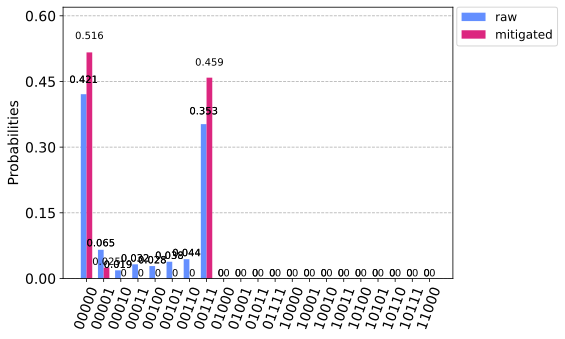

In [17]:
"""次に、測定結果に対して校正行列を適用し、元の測定結果と比較する

校正により、エラーによって生じていた|00000>, |00111>以外の結果が減っていることがわかる。

このように、エラーの影響を受けた測定結果から、理想的な場合に得られる確率分布により近い結果を推定することができる。
"""
# 測定された生の値
raw_counts = results.get_counts()

# 校正行列により補正した値
mitigated_results = meas_fitter.filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

# ヒストグラムで比較表示
plot_histogram([raw_counts, mitigated_counts], legend=["raw", "mitigated"])